# OPEN METEO API

In [3]:
#Install
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/61.4 kB ? eta -:--:--
   -------------------- ------------------- 30.7/61.4 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 61.4/61.4 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
   ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#Import Dependencies
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

In [ ]:
#Setup the Open-Meteo API Client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [ ]:
#Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [36.154, 40.7128, 34.0549],
	"longitude": [95.9928, 74.006, 118.2426],
	"start_date": "2014-01-01",
	"end_date": "2023-12-31",
	"hourly": "relative_humidity_2m",
	"daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
	"temperature_unit": "fahrenheit",
	"precipitation_unit": "inch",
	"timezone": "America/Chicago"
}
responses = openmeteo.weather_api(url, params=params)

In [ ]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

In [ ]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

In [ ]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["precipitation_sum"] = daily_precipitation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

# EPA API CONCATED

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv('Resources/EPA.env')

api_key = os.getenv('EPA_API_KEY')
email_key = os.getenv('MY_EMAIL')


def fetch_aqi_data(year, api_key, cbsa):
    url = 'https://aqs.epa.gov/data/api/annualData/byCBSA'
    params = {
        'email': email_key,
        'key': api_key,
        'param': '88101',  # Parameter code for PM2.5
        'bdate': f'{year}0101',
        'edate': f'{year}1231',
        'cbsa': cbsa  # CBSA defined in cbsa_codes
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['Data'])

# Define the range of years / CBSA
years = range(2014, 2024)  # Adjust this range as needed
cbsa_codes = {
    'Tulsa': '46140',
    'Los Angeles': '31080',
    'New York': '35620'
}
# Fetch and concatenate data for each year
# all_data = pd.DataFrame()
# for year in years:
#     yearly_data = fetch_aqi_data(year, api_key)
#     all_data = pd.concat([all_data, yearly_data])
all_data = pd.DataFrame()

for cbsa_name, cbsa_code in cbsa_codes.items():
    for year in years:
        yearly_data = fetch_aqi_data(year, api_key, cbsa_code)
        if not yearly_data.empty:
            yearly_data['CBSA'] = cbsa_name
            yearly_data['year'] = year
            all_data = pd.concat([all_data, yearly_data], ignore_index=True)

# Reset the index after concatenation
all_data.reset_index(drop=True, inplace=True)



# View the combined DataFrame
print(all_data.head())
print(all_data.tail())

  state_code county_code site_number parameter_code  poc   latitude  \
0         40         143        0174          88101    3  35.953708   
1         40         143        0174          88101    3  35.953708   
2         40         143        0174          88101    3  35.953708   
3         40         143        0174          88101    3  35.953708   
4         40         143        0174          88101    3  35.953708   

   longitude  datum                 parameter sample_duration_code  ...  \
0 -96.004975  WGS84  PM2.5 - Local Conditions                    1  ...   
1 -96.004975  WGS84  PM2.5 - Local Conditions                    X  ...   
2 -96.004975  WGS84  PM2.5 - Local Conditions                    X  ...   
3 -96.004975  WGS84  PM2.5 - Local Conditions                    X  ...   
4 -96.004975  WGS84  PM2.5 - Local Conditions                    X  ...   

  tenth_percentile local_site_name         site_address     state  county  \
0              3.3     TULSA SOUTH  502 EAST 

# DATA CONCATED 

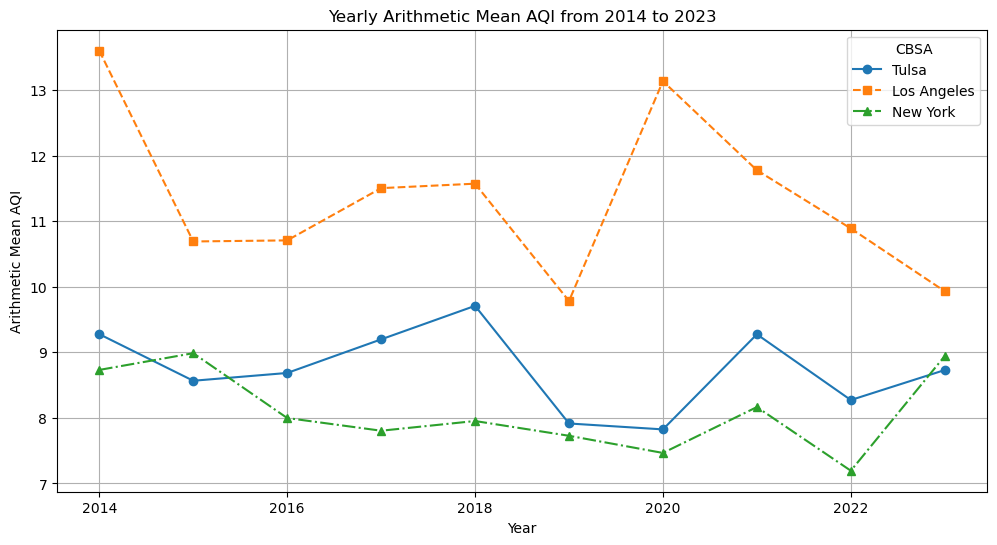

In [5]:
#Code to Combine Data (Under Construction)
# Yearly arithmetic mean for each CBSA
if not all_data.empty:
    # Convert 'arithmetic_mean' to numeric, coerce errors to NaN
    all_data['arithmetic_mean'] = pd.to_numeric(all_data['arithmetic_mean'], errors='coerce')

    yearly_aqi = all_data[all_data['arithmetic_mean'].notna()].groupby(['CBSA', 'year'])['arithmetic_mean'].mean().reset_index()

    # Plot 
    plt.figure(figsize=(12, 6))
    markers = ['o', 's', '^']  # Different markers - CBSA
    linestyles = ['-', '--', '-.']  # Different line - CBSA
    for idx, cbsa in enumerate(cbsa_codes.keys()):
        cbsa_data = yearly_aqi[yearly_aqi['CBSA'] == cbsa]
        if not cbsa_data.empty:
            plt.plot(cbsa_data['year'], cbsa_data['arithmetic_mean'],
                     marker=markers[idx % len(markers)], linestyle=linestyles[idx % len(linestyles)], label=cbsa)

    plt.title('Yearly Arithmetic Mean AQI from 2014 to 2023')
    plt.xlabel('Year')
    plt.ylabel('Arithmetic Mean AQI')
    plt.legend(title='CBSA')
    plt.grid(True)
    plt.show()
else:
    print("No valid data to plot.")

In [6]:
# Reset index 'first_max_datetime' to datetime
all_data.reset_index(drop=True, inplace=True)
if 'first_max_datetime' in all_data.columns:
    all_data['first_max_datetime'] = pd.to_datetime(all_data['first_max_datetime'])

# Convert 'first_max_value' to numbers, coerce errors 
if 'first_max_value' in all_data.columns:
    all_data['first_max_value'] = pd.to_numeric(all_data['first_max_value'], errors='coerce')

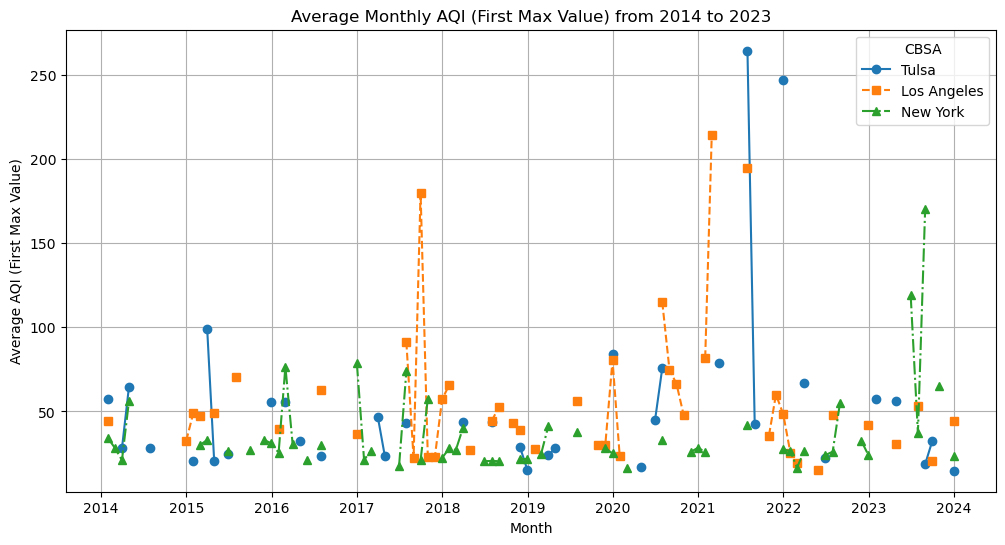

In [7]:
# Change to month and fill missing values
if not all_data.empty and 'first_max_datetime' in all_data.columns:
    all_data.set_index('first_max_datetime', inplace=True)
    monthly_aqi = all_data[all_data['first_max_value'].notna()].groupby('CBSA').resample('ME')['first_max_value'].mean()
    monthly_aqi = monthly_aqi.reset_index()

    # Plot 
    plt.figure(figsize=(12, 6))
    markers = ['o', 's', '^']  # Different markers - CBSA
    linestyles = ['-', '--', '-.']  # Different line - CBSA
    for idx, cbsa in enumerate(cbsa_codes.keys()):
        cbsa_data = monthly_aqi[monthly_aqi['CBSA'] == cbsa]
        if not cbsa_data.empty:
            plt.plot(cbsa_data['first_max_datetime'], cbsa_data['first_max_value'],
                     marker=markers[idx % len(markers)], linestyle=linestyles[idx % len(linestyles)], label=cbsa)

    plt.title('Average Monthly AQI (First Max Value) from 2014 to 2023')
    plt.xlabel('Month')
    plt.ylabel('Average AQI (First Max Value)')
    plt.legend(title='CBSA')
    plt.grid(True)
    plt.show()
else:
    print("No valid data to plot.")

In [10]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv
import time

# Load environment variables
load_dotenv('Resources/EPA.env')

api_key = os.getenv('EPA_API_KEY')
email_key = os.getenv('MY_EMAIL')

def fetch_aqi_data(year, quarter, api_key, cbsa):
    url = 'https://aqs.epa.gov/data/api/quarterlyData/byCBSA'
    params = {
        'email': email_key,
        'key': api_key,
        'param': '88101',  # Parameter code for PM2.5
        'bdate': f'{year}{quarter[0]}',
        'edate': f'{year}{quarter[1]}',
        'cbsa': cbsa  # CBSA code for the city
    }
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()  # Raise an error for bad status codes
        data = response.json()
        return pd.DataFrame(data['Data'])
    except requests.exceptions.Timeout:
        print(f"Request timed out for year {year}, quarter {quarter}, CBSA {cbsa}")
        return pd.DataFrame()  # Return an empty DataFrame on timeout
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on request failure

# Define the range of years and CBSA codes
years = range(2014, 2024)  # Adjust this range as needed
cbsa_codes = {
    'Tulsa': '46140',
    'Los Angeles': '31080',
    'New York': '35620'
}

# Define quarters
quarters = {
    'Q1': ('0101', '0331'),
    'Q2': ('0401', '0630'),
    'Q3': ('0701', '0930'),
    'Q4': ('1001', '1231')
}

# Process data city by city
for cbsa_name, cbsa_code in cbsa_codes.items():
    all_data = pd.DataFrame()
    print(f"Fetching data for {cbsa_name}...")
    for year in years:
        for quarter_name, quarter_dates in quarters.items():
            quarterly_data = fetch_aqi_data(year, quarter_dates, api_key, cbsa_code)
            if not quarterly_data.empty:
                quarterly_data['CBSA'] = cbsa_name
                quarterly_data['Year'] = year
                quarterly_data['Quarter'] = quarter_name
                all_data = pd.concat([all_data, quarterly_data], ignore_index=True)
            time.sleep(1)  # Add a small delay between requests to avoid overwhelming the API
    
    # Reset the index after concatenation
    all_data.reset_index(drop=True, inplace=True)
    
    # Save the data for each city to a CSV file for further analysis
    all_data.to_csv(f'{cbsa_name}_AQI_data.csv', index=False)
    print(f"Data for {cbsa_name} saved to {cbsa_name}_AQI_data.csv")

    # Check if the 'Quarter' column exists in the DataFrame
    if 'Quarter' in all_data.columns:
        print(f"The 'Quarter' column is present in the DataFrame for {cbsa_name}.")
    else:
        print(f"The 'Quarter' column is NOT present in the DataFrame for {cbsa_name}.")


Fetching data for Tulsa...
Data for Tulsa saved to Tulsa_AQI_data.csv
The 'Quarter' column is present in the DataFrame for Tulsa.
Fetching data for Los Angeles...
Data for Los Angeles saved to Los Angeles_AQI_data.csv
The 'Quarter' column is present in the DataFrame for Los Angeles.
Fetching data for New York...
Data for New York saved to New York_AQI_data.csv
The 'Quarter' column is present in the DataFrame for New York.
